In [81]:
import matplotlib.pyplot as plt
import random
import numpy as np
from numba import jit
from numba import int32, float32    # import the types
from numba.experimental import jitclass

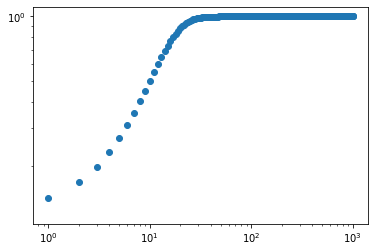

In [3]:
def sigmoid(x, theta3): 
    theta1 = 1
    theta2 = 0.2
    xi = 1
    return theta1/(1+xi*np.exp(-theta2*(x-theta3)))**(1/xi)

x = np.array(range(1000))
plt.scatter(x, (sigmoid(x,10)))
plt.loglog()
plt.show()

In [186]:
spec = [
    ('free_mean_path_para', float32),               # a simple scalar field
    ('free_mean_path_perp', float32), 
    ('gyro_radius', float32), 
    ('t', float32),
    ('pos', float32[:]),          # an array field
    ('direction', float32[:])
]

@jitclass(spec)
class particle():
    def __init__(self, gyro_radius, free_mean_path_para, free_mean_path_perp):
        self.gyro_radius = gyro_radius
        self.free_mean_path_para = free_mean_path_para
        self.free_mean_path_perp = free_mean_path_perp
        self.t = 0
        self.pos = np.zeros(3, dtype=np.float32)
        self.direction = np.ones(3, dtype=np.float32)
        
            
     
    def move(self, step_size):
        p = 1.0*step_size
        self.t = self.t + 1*step_size
        
        #if sigmoid(self.t, self.gyro_radius) >= random.random():
        if self.t > self.gyro_radius:
            # after gyroradius ~ half gyroorbit, particle 
            # needs to change direction perp to background field
            if (random.randint(0, self.free_mean_path_perp) == 1):
                self.direction[0] = self.direction[0]*(-1)
            if (random.randint(0, self.free_mean_path_perp) == 0):
                self.direction[1] = self.direction[1]*(-1)
        if self.t > self.free_mean_path_para:
            # after mean-free length, particle can also change 
            # direction parallel to mean field
            if (random.randint(0, self.free_mean_path_para) == 0):
                self.direction[2] = self.direction[2]*(-1)
            
        absDirection = (self.direction[0]**2+self.direction[1]**2+self.direction[2]**2)**0.5
        #absDirection = self.direction.absValue()
        
        #if direction == 0:
        self.pos[0] = self.pos[0] + p*self.direction[0]/absDirection
        self.pos[1] = self.pos[1] + p*self.direction[1]/absDirection
        self.pos[2] = self.pos[2] + p*self.direction[2]/absDirection

In [187]:
pos = [0,0]
steps = 10**5
t_max = 10**5
time = np.linspace(1, t_max, steps)
step = t_max / steps
old_time = 0

gyro_radius = 30
free_mean_path_para = 200
free_mean_path_perp = 10



In [189]:
# generate particles
particles = []
for j in range(500):
    particles.append(particle(gyro_radius, free_mean_path_para, free_mean_path_perp))
    
@jit(nopython=True)
def run_simulation(particles, time):
    kappa_perp = []
    kappa_para = []
    for i, t in enumerate(time):
        kappa_perp_sum = 0
        kappa_para_sum = 0
        for p in particles:
            p.move(step)
            kappa_perp_sum = kappa_perp_sum + p.pos[0]**2+p.pos[1]**2
            kappa_para_sum = kappa_para_sum + p.pos[2]**2
        
        kappa_para.append(kappa_para_sum/(2*t*len(particles)))
        kappa_perp.append(kappa_perp_sum/(4*t*len(particles)))

    return [kappa_para, kappa_perp]

In [190]:
%time kappa = run_simulation(particles, time)
kappa_para = kappa[0]
kappa_perp = kappa[1]

/home/patrick/.local/lib/python3.8/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'particles' of function 'run_simulation'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-189-ece8f39abe73>", line 7:
@jit(nopython=True)
def run_simulation(particles, time):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


CPU times: user 3.76 s, sys: 4.02 ms, total: 3.76 s
Wall time: 3.76 s


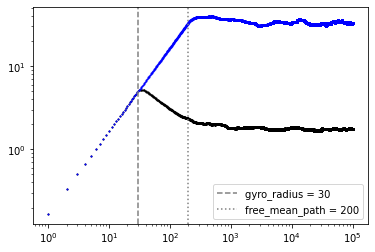

In [191]:
plt.scatter(time, kappa_perp, c='k', s=1)
#plt.scatter(range(1,n), kappa_y, c='r')
plt.scatter(time, kappa_para, c='b', s=1)
plt.axvline(x=gyro_radius, color = 'grey', ls='--', label='gyro_radius = '+str(gyro_radius))
plt.axvline(x=free_mean_path_para, color = 'grey', ls=':', label='free_mean_path = '+str(free_mean_path_para))
plt.xscale('log')
plt.yscale('log')
plt.legend('$d$ [pc]')
plt.legend()
plt.show()

In [192]:
print(np.mean(kappa_perp[-1000:-1]))
print(np.mean(kappa_para[-1000:-1]))

1.755706875903226
32.7477577416401
